<a href="https://colab.research.google.com/github/komh9575/first-repository/blob/main/Part2_Clustering_%E1%84%89%E1%85%B5%E1%86%AF%E1%84%89%E1%85%B3%E1%86%B8%E1%84%8B%E1%85%AD%E1%86%BC_260204.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 2: K-Means 클러스터링을 활용한 고객 세그멘테이션

## 📚 학습 목표

1. **비지도 학습(Unsupervised Learning)**의 개념 이해
2. **K-Means 클러스터링** 알고리즘의 원리와 활용
3. **데이터 전처리**: 로그 변환, 스케일 조정의 중요성
4. **최적 클러스터 수 결정**: Elbow Method, Silhouette Score
5. **고객 세그멘테이션**: 규칙 기반(RFM) vs 데이터 기반(Clustering) 비교
6. **비즈니스 인사이트** 도출 및 마케팅 전략 수립

## 📊 데이터셋 소개

- **입력 데이터**: Part 1에서 생성한 `rfm.csv` 파일
- **데이터 구성**: CustomerID, Recency, Frequency, MonetaryValue, RFM_class 등
- **분석 목적**: RFM 지표를 기반으로 머신러닝을 통한 고객 군집화

## 🔄 분석 흐름

1. RFM 데이터 로드
2. 데이터 전처리 (로그 변환, 스케일 조정)
3. K-Means 클러스터링 수행
4. 최적 클러스터 수 결정 (Elbow Method, Silhouette Score)
5. 클러스터 분석 및 시각화
6. 규칙 기반(RFM) vs 데이터 기반(Clustering) 비교
7. 비즈니스 인사이트 도출

---


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
path='/content/drive/MyDrive/Colab Notebooks/rfm.csv'
df = pd.read_csv(path)

## 1. 환경 설정 및 라이브러리 임포트


In [15]:
# TODO: 필요한 라이브러리 임포트
!pip install koreanize-matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

## 2. 군집화(Clustering) 개념 이해

### 📖 군집화란?

**군집화(Clustering)**는 비지도 학습(Unsupervised Learning)의 대표적인 기법입니다.

- **목적**: 레이블(정답)이 없는 데이터에서 유사한 특성을 가진 데이터들을 그룹으로 묶는 것
- **특징**: 정답이 없으므로 데이터 자체의 패턴을 찾아내는 것
- **활용**: 고객 세그멘테이션, 이미지 분할, 이상 탐지 등

### 🎯 K-Means 클러스터링

**K-Means**는 가장 널리 사용되는 클러스터링 알고리즘입니다.

#### 알고리즘 동작 원리:

1. **초기화**: K개의 중심점(centroid)을 랜덤하게 선택
2. **할당**: 각 데이터 포인트를 가장 가까운 중심점에 할당
3. **업데이트**: 각 클러스터의 중심점을 재계산
4. **반복**: 2-3단계를 수렴할 때까지 반복

#### 장점:

- 구현이 간단하고 빠름
- 대용량 데이터에 효율적
- 해석이 쉬움

#### 단점:

- 클러스터 수(K)를 미리 지정해야 함
- 초기 중심점에 따라 결과가 달라질 수 있음
- 비구형 클러스터에는 부적합

### 📚 참고 자료

- [Clustering — scikit-learn documentation](https://scikit-learn.org/stable/modules/clustering.html#clustering)
- [k-평균 알고리즘 - 위키백과](https://ko.wikipedia.org/wiki/K-%ED%8F%89%EA%B7%A0_%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98)


## 3. 데이터 로드


In [18]:
import pandas as pd
# TODO: RFM 데이터를 로드하세요 (index_col을 사용하여 CustomerID를 인덱스로 설정)
# pd.read_csv()를 사용하여 'rfm.csv' 파일을 로드하세요
# index_col="CustomerID"를 사용하여 CustomerID를 인덱스로 설정하세요
rfm = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/rfm.csv', index_col=1)
rfm.head()

,CustomerID,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class
Recency,,,,,,,,,
326,12346.0,1,77183.60,1,1,5,115,7,bronze
2,12347.0,182,4310.00,5,5,5,555,15,gold
75,12348.0,27,1595.64,2,2,4,224,8,silver
19,12349.0,73,1757.55,4,4,4,444,12,gold
310,12350.0,17,334.40,1,2,2,122,5,bronze


In [23]:
# TODO: 클러스터링에 사용할 RFM 값만 추출하세요 (Recency, Frequency, MonetaryValue)
# Recency가 인덱스이므로 reset_index()를 사용하여 컬럼으로 변환 후 선택하세요
rfm_cluster = rfm.reset_index()[['Recency', 'Frequency', 'MonetaryValue']]
rfm_cluster.head()

,Recency,Frequency,MonetaryValue
0,326,1,77183.60
1,2,182,4310.00
2,75,27,1595.64
3,19,73,1757.55
4,310,17,334.40


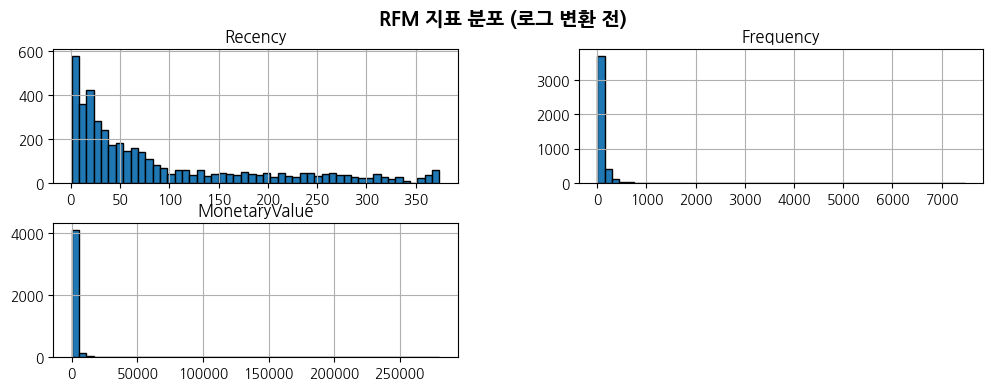

💡 관찰:
- Recency, Frequency, MonetaryValue 모두 정규 분포가 아님
- 특히 MonetaryValue는 매우 치우친 분포 (skewed)
- 클러스터링을 위해서는 정규화가 필요함


In [24]:
# RFM 데이터 분포 확인
rfm_cluster.hist(bins=50, figsize=(12, 4), edgecolor='black')
plt.suptitle('RFM 지표 분포 (로그 변환 전)', fontsize=14, fontweight='bold')
plt.show()

print("💡 관찰:")
print("- Recency, Frequency, MonetaryValue 모두 정규 분포가 아님")
print("- 특히 MonetaryValue는 매우 치우친 분포 (skewed)")
print("- 클러스터링을 위해서는 정규화가 필요함")

## 4. 데이터 전처리

### 4.1 로그 변환 (Log Transformation)

### 📖 로그 변환이란?

**로그(log)**는 지수 함수의 역함수입니다. 어떤 수를 나타내기 위해 고정된 밑을 몇 번 곱하여야 하는지를 나타냅니다.

#### 왜 로그 변환이 필요한가?

- **K-Means는 거리 기반 알고리즘**: 유클리드 거리를 사용
- **스케일 차이**: MonetaryValue가 매우 크면 다른 변수에 비해 과도한 영향
- **비대칭 분포**: 치우친 분포는 클러스터링 성능 저하
- **정규 분포 가정**: 많은 머신러닝 알고리즘이 정규 분포를 가정

#### 로그 변환의 효과:

- 큰 값과 작은 값의 차이를 줄임
- 정규 분포에 가까운 형태로 변환
- 이상치의 영향을 감소
- 곱셈 관계를 덧셈 관계로 변환

#### 로그의 종류:

- **자연로그 (Natural Logarithm)**: 밑이 e (약 2.718) - `np.log()`, `np.log1p()`
- **상용로그 (Common Logarithm)**: 밑이 10 - `np.log10()`

<img src="https://upload.wikimedia.org/wikipedia/commons/8/81/Logarithm_plots.png" width="500">

#### 주의사항:

- `log(0) = -∞`이므로 `log1p()` 사용 (log(1+x))
- 또는 `log(x + 1)` 사용
- 음수 값은 로그 변환 불가

### 📚 참고 자료

- [로그 (수학) - 위키백과](<https://ko.wikipedia.org/wiki/%EB%A1%9C%EA%B7%B8_(%EC%88%98%ED%95%99)>)
- [자연로그 - 위키백과](https://ko.wikipedia.org/wiki/%EC%9E%90%EC%97%B0%EB%A1%9C%EA%B7%B8)
- [상용로그 - 위키백과](https://ko.wikipedia.org/wiki/%EC%83%81%EC%9A%A9%EB%A1%9C%EA%B7%B8)


In [25]:
# TODO: 로그 변환을 적용하세요 (np.log1p()를 사용하여 0 값도 안전하게 처리)
# np.log1p()를 사용하여 로그 변환하세요
rfm_cluster_log = np.log1p(rfm_cluster)
rfm_cluster_log




,Recency,Frequency,MonetaryValue
0,5.789960,0.693147,11.253955
1,1.098612,5.209486,8.368925
2,4.330733,3.332205,7.375657
3,2.995732,4.304065,7.472245
4,5.739793,2.890372,5.815324
...,...,...,...
4333,5.631212,2.397895,5.201806
4334,5.204007,2.079442,4.404522
4335,2.197225,2.564949,5.187665
4336,1.609438,6.536692,7.586438


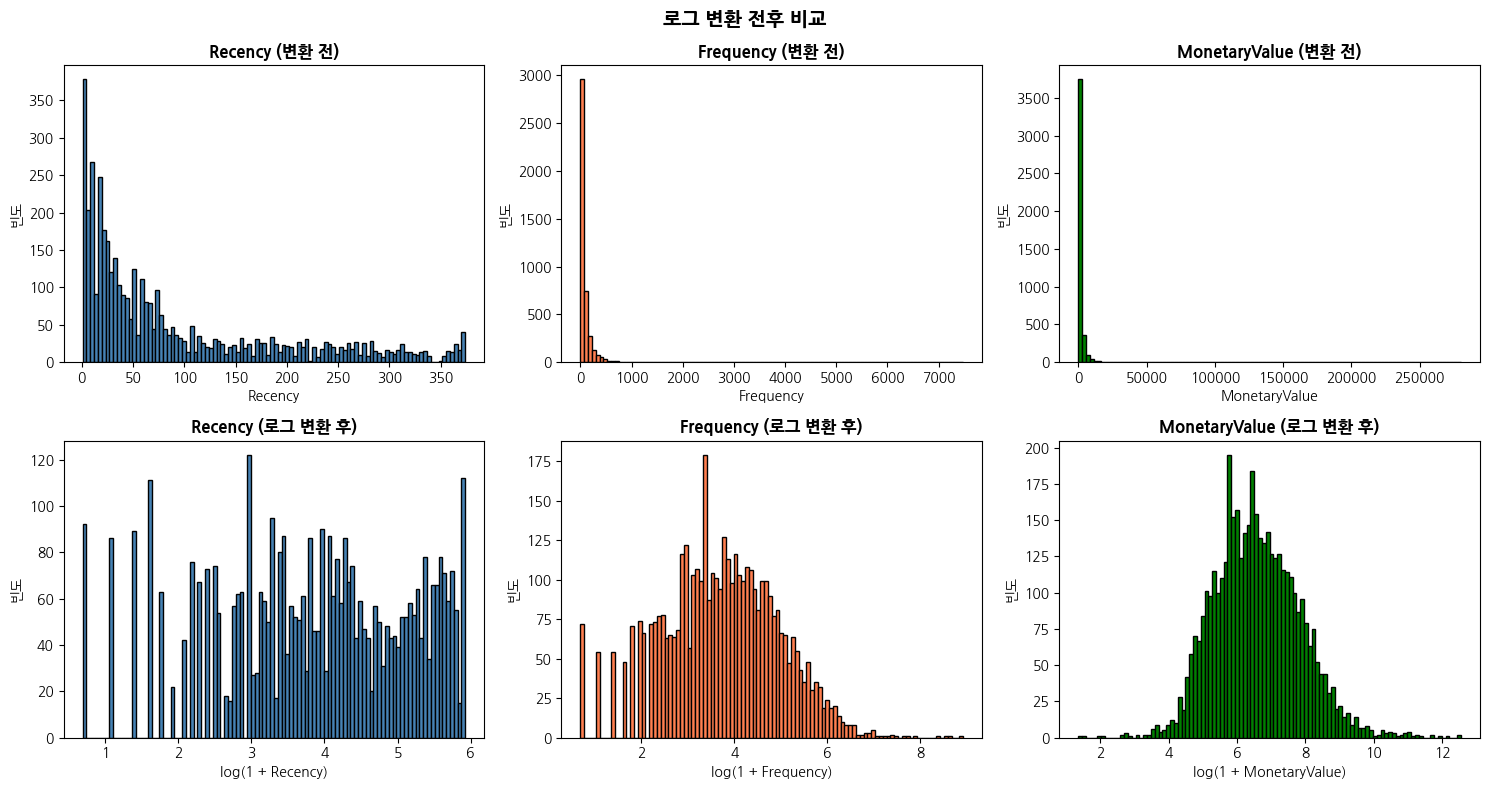

💡 관찰:
- 로그 변환 후 분포가 더 정규 분포에 가까워짐
- 특히 MonetaryValue의 치우침이 크게 개선됨


In [26]:
# 로그 변환 전후 비교 시각화
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# 변환 전
axes[0, 0].hist(rfm_cluster['Recency'], bins=100, edgecolor='black', color='steelblue')
axes[0, 0].set_title('Recency (변환 전)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Recency')
axes[0, 0].set_ylabel('빈도')

axes[0, 1].hist(rfm_cluster['Frequency'], bins=100, edgecolor='black', color='coral')
axes[0, 1].set_title('Frequency (변환 전)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Frequency')
axes[0, 1].set_ylabel('빈도')

axes[0, 2].hist(rfm_cluster['MonetaryValue'], bins=100, edgecolor='black', color='green')
axes[0, 2].set_title('MonetaryValue (변환 전)', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('MonetaryValue')
axes[0, 2].set_ylabel('빈도')

# 변환 후
axes[1, 0].hist(rfm_cluster_log['Recency'], bins=100, edgecolor='black', color='steelblue')
axes[1, 0].set_title('Recency (로그 변환 후)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('log(1 + Recency)')
axes[1, 0].set_ylabel('빈도')

axes[1, 1].hist(rfm_cluster_log['Frequency'], bins=100, edgecolor='black', color='coral')
axes[1, 1].set_title('Frequency (로그 변환 후)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('log(1 + Frequency)')
axes[1, 1].set_ylabel('빈도')

axes[1, 2].hist(rfm_cluster_log['MonetaryValue'], bins=100, edgecolor='black', color='green')
axes[1, 2].set_title('MonetaryValue (로그 변환 후)', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('log(1 + MonetaryValue)')
axes[1, 2].set_ylabel('빈도')

plt.suptitle('로그 변환 전후 비교', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("💡 관찰:")
print("- 로그 변환 후 분포가 더 정규 분포에 가까워짐")
print("- 특히 MonetaryValue의 치우침이 크게 개선됨")

### 4.2 스케일 조정 (Scaling)

### 📖 스케일 조정이란?

**스케일 조정**은 변수 간의 스케일 차이를 제거하여 모든 변수가 동일한 범위를 갖도록 만드는 전처리 기법입니다.

#### 왜 스케일 조정이 필요한가?

- **K-Means는 거리 기반**: 유클리드 거리를 계산
- **스케일 차이**: MonetaryValue가 매우 크면 거리 계산 시 과도한 영향
- **공정한 비교**: 모든 변수가 동일한 가중치를 갖도록
- **알고리즘 성능**: 거리 기반 알고리즘의 성능 향상

#### 주요 스케일러:

1. **StandardScaler** (표준화) ⭐ **가장 널리 사용**
   - 공식: `z = (x - μ) / σ`
   - 평균(μ)을 빼고 표준편차(σ)로 나눔
   - 결과: 평균 0, 표준편차 1
   - 장점: 정규 분포에 적합, 해석이 쉬움
   - 단점: 이상치에 민감

2. **MinMaxScaler** (정규화)
   - 공식: `x_scaled = (x - min) / (max - min)`
   - 최솟값을 0, 최댓값을 1로 변환
   - 범위가 0~1로 고정
   - 장점: 범위가 명확함
   - 단점: 이상치에 매우 민감

3. **RobustScaler** (강건한 스케일링)
   - 중앙값(median)과 IQR(사분위수 범위) 사용
   - 공식: `x_scaled = (x - median) / IQR`
   - 장점: 이상치에 강함
   - 단점: 해석이 어려울 수 있음

#### Scikit-learn API 사용법:

- **fit()**: 학습 (평균, 표준편차 등을 계산)
- **transform()**: 변환 (학습한 파라미터로 변환)
- **fit_transform()**: 학습과 변환을 한 번에 수행
- **inverse_transform()**: 역변환 (원래 스케일로 복원)


In [29]:
# TODO: StandardScaler를 임포트하고 스케일 조정을 수행하세요
# from sklearn.preprocessing import StandardScaler를 사용하세요
# StandardScaler를 생성하고 fit_transform()을 사용하여 스케일 조정하세요
# DataFrame으로 변환하여 컬럼명과 인덱스를 유지하세요

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = ss.fit_transform(rfm_cluster_log)

X = pd.DataFrame(X, columns=rfm_cluster_log.columns
                 , index=rfm_cluster_log.index)
X = X.reset_index()
X.head()


,index,Recency,Frequency,MonetaryValue
0,0,1.461907,-2.439151,3.712290
1,1,-2.040527,1.199504,1.421604
2,2,0.372488,-0.312956,0.632958
3,3,-0.624188,0.470038,0.709649
4,4,1.424454,-0.668925,-0.605931


In [30]:
X.describe().round(2)

,index,Recency,Frequency,MonetaryValue
count,4338.00,4338.00,4338.00,4338.00
mean,2168.50,0.00,-0.00,-0.00
std,1252.42,1.00,1.00,1.00
min,0.00,-2.34,-2.44,-4.14
25%,1084.25,-0.66,-0.67,-0.68
50%,2168.50,0.09,0.01,-0.07
75%,3252.75,0.85,0.70,0.66
max,4337.00,1.56,4.19,4.74


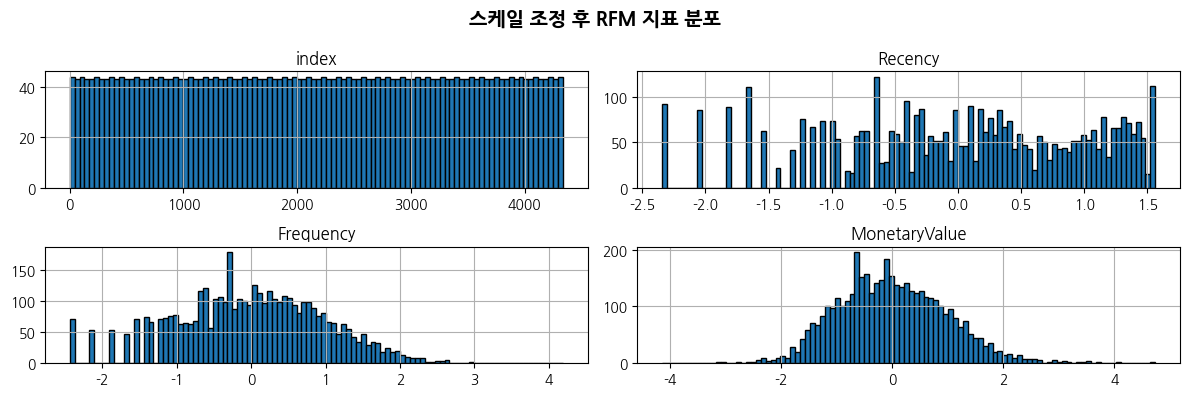

💡 관찰:
- 분포 형태는 로그 변환 후와 동일 (분포는 유지)
- 스케일만 조정됨 (평균 0, 표준편차 1)
- 이제 클러스터링에 적합한 데이터가 됨


In [32]:
# 스케일 조정 후 분포 확인
X.hist(bins=100, figsize=(12, 4), edgecolor='black')
plt.suptitle('스케일 조정 후 RFM 지표 분포', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("💡 관찰:")
print("- 분포 형태는 로그 변환 후와 동일 (분포는 유지)")
print("- 스케일만 조정됨 (평균 0, 표준편차 1)")
print("- 이제 클러스터링에 적합한 데이터가 됨")

## 5. K-Means 클러스터링

### 📖 K-Means 알고리즘

#### 알고리즘 동작 과정:

1. **초기화**: K개의 중심점(centroid)을 랜덤하게 선택
2. **할당(Assignment)**: 각 데이터 포인트를 가장 가까운 중심점에 할당
3. **업데이트(Update)**: 각 클러스터의 중심점을 재계산 (평균)
4. **수렴 확인**: 중심점이 더 이상 변하지 않을 때까지 2-3단계 반복

#### 주요 파라미터:

- **n_clusters**: 클러스터 수 (K)
- **init**: 초기 중심점 선택 방법 ('k-means++' 권장)
- **n_init**: 다른 초기값으로 실행할 횟수
- **max_iter**: 최대 반복 횟수
- **random_state**: 재현성을 위한 시드값


In [35]:
# TODO: KMeans를 임포트하고 예시로 K=8로 클러스터링을 수행해보세요
# from sklearn.cluster import KMeans를 사용하세요
# KMeans(n_clusters=8, random_state=42, n_init='auto')를 생성하고 fit()을 사용하여 학습하세요

from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=8, random_state=42, n_init='auto')
kmeans_model.fit(X) # X는 스케일링된 RFM 데이터

KMeans(random_state=42)

In [36]:
kmeans_model.cluster_centers_

array([[ 1.82150000e+03, -7.62683273e-02,  6.29215669e-02,
         1.12904840e-02],
       [ 4.05100000e+03,  1.91882168e-02, -5.70955588e-02,
        -1.42647612e-01],
       [ 2.55500000e+02, -2.70067560e-02,  6.25573916e-02,
         2.68511562e-01],
       [ 2.91700000e+03,  2.39540347e-02, -2.20105805e-02,
        -3.39635179e-02],
       [ 7.70000000e+02,  8.28134203e-03, -3.93388556e-02,
        -6.66672679e-03],
       [ 2.36350000e+03,  9.81896631e-02, -4.78691177e-02,
        -7.94335568e-02],
       [ 1.29100000e+03, -8.75903592e-03,  8.09135060e-03,
         6.70855831e-02],
       [ 3.48050000e+03, -4.07900820e-02,  3.80049844e-02,
        -5.46665058e-02]])

## 6. 최적 클러스터 수 결정

### 📖 최적 K를 찾는 방법

K-Means에서 가장 중요한 문제는 **최적의 클러스터 수(K)를 결정**하는 것입니다.

#### 1. Elbow Method (엘보우 방법)

**Inertia (Within-Cluster Sum of Squares)**를 사용합니다.

- Inertia: 각 데이터 포인트와 해당 클러스터 중심점 간의 거리 제곱의 합
- K가 증가할수록 Inertia는 감소
- **엘보우 포인트**: Inertia가 급격히 감소하는 지점

#### 2. Silhouette Score (실루엣 점수)

**클러스터링 품질**을 평가하는 지표입니다.

- 범위: -1 ~ 1 (1에 가까울수록 좋음)
- **a**: 같은 클러스터 내 평균 거리 (응집도)
- **b**: 가장 가까운 다른 클러스터까지의 평균 거리 (분리도)
- **공식**: `s = (b - a) / max(a, b)`
- `silhouette_samples(X, labels, metric='euclidean', **kwds)` : X feature 데이터 세트와 각 feature데이터 세트가 속한 군집 레이블 값인 labels데이터를 입력해주면 각 데이터 포인트의 실루엣 계수를 계산해 반환
- `silhouette_score(X, labels, metric='euclidean', sample_size=None, **kwds)`:
  - 인자로 X feature데이터 세트와 각 feature 데이터 세트가 속한 레이블 값인 labels데이터를 입력해주면 전체 데이터의 실루엣 계수 값을 평균해 반환
  - np.mean(silhouette_samples())


In [39]:
# TODO: 다양한 K 값에 대해 Inertia와 Silhouette Score를 계산하세요
# from sklearn.metrics import silhouette_score를 사용하세요
# range(2, 21)을 사용하여 K=2부터 20까지 반복하세요
# 각 K에 대해 KMeans를 학습하고 inertia와 silhouette_score를 계산하세요

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

inertia = []
silhouettes = []
range_n_clusters = range(2, 20+1)

for n_cluster in range_n_clusters:
  kmeans = KMeans(n_clusters=n_cluster, random_state=42, n_init='auto')
  kmeans.fit(X.drop(columns=['index'])) # 'index' 컬럼 제외하고 학습
  inertia.append(kmeans.inertia_)
  silhouettes.append(silhouette_score(X.drop(columns=['index']), kmeans.labels_))

  print(inertia)
  print(silhouettes)

[6778.434418139641]
[np.float64(0.39973400327304887)]
[6778.434418139641, 5239.448686220979]
[np.float64(0.39973400327304887), np.float64(0.3034406883346046)]
[6778.434418139641, 5239.448686220979, 4301.8870220426215]
[np.float64(0.39973400327304887), np.float64(0.3034406883346046), np.float64(0.3089325037890988)]
[6778.434418139641, 5239.448686220979, 4301.8870220426215, 3688.9796215143188]
[np.float64(0.39973400327304887), np.float64(0.3034406883346046), np.float64(0.3089325037890988), np.float64(0.27713458533136187)]
[6778.434418139641, 5239.448686220979, 4301.8870220426215, 3688.9796215143188, 3260.876652228926]
[np.float64(0.39973400327304887), np.float64(0.3034406883346046), np.float64(0.3089325037890988), np.float64(0.27713458533136187), np.float64(0.27409867551677825)]
[6778.434418139641, 5239.448686220979, 4301.8870220426215, 3688.9796215143188, 3260.876652228926, 2972.675317617008]
[np.float64(0.39973400327304887), np.float64(0.3034406883346046), np.float64(0.3089325037890988

### 6.1 Elbow Method 시각화


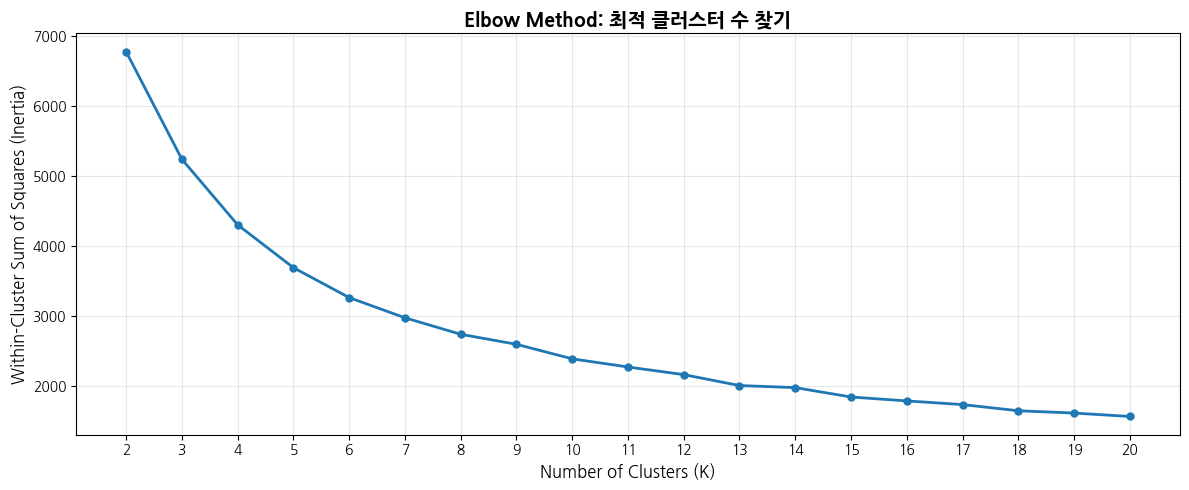

💡 해석:
- K가 증가할수록 Inertia는 감소
- 엘보우 포인트(급격히 감소하는 지점)를 찾아야 함
- 일반적으로 K=3~5 정도가 적절해 보임


In [43]:
# TODO: Elbow Method를 시각화하세요
plt.figure(figsize=(12, 5))
plt.plot(range_n_clusters, inertia, marker='o', linewidth=2, markersize=5)
plt.title('Elbow Method: 최적 클러스터 수 찾기', fontsize=14, fontweight='bold')
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (Inertia)', fontsize=12)
plt.xticks(range_n_clusters)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("💡 해석:")
print("- K가 증가할수록 Inertia는 감소")
print("- 엘보우 포인트(급격히 감소하는 지점)를 찾아야 함")
print("- 일반적으로 K=3~5 정도가 적절해 보임")

### 6.2 Silhouette Score 시각화

#### 좋은 클러스터링의 조건:

1. 전체 실루엣 점수의 평균값이 높음 (0.5 이상 권장)
2. 모든 클러스터의 평균 실루엣 점수가 비슷함 (균형)
3. 클러스터 내 실루엣 점수가 균일함


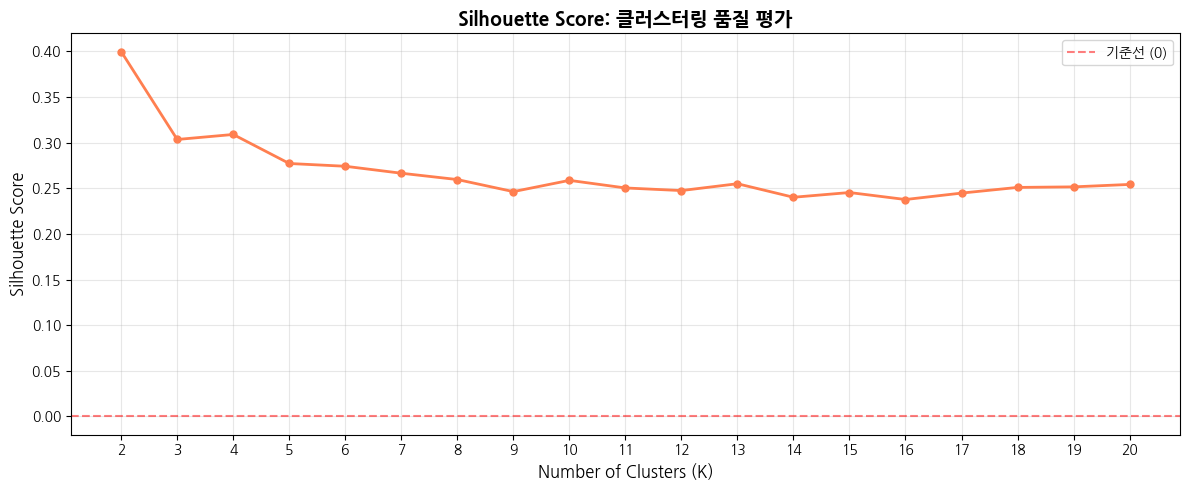

💡 최적 클러스터 수:
   - 최고 Silhouette Score: K=2, Score=0.400

클러스터 수별 Silhouette Score:
   K= 2: 0.400 ⭐
   K= 3: 0.303
   K= 4: 0.309
   K= 5: 0.277
   K= 6: 0.274
   K= 7: 0.266
   K= 8: 0.260
   K= 9: 0.246
   K=10: 0.259
   K=11: 0.250
   K=12: 0.247
   K=13: 0.255
   K=14: 0.240
   K=15: 0.245
   K=16: 0.238
   K=17: 0.245
   K=18: 0.251
   K=19: 0.252
   K=20: 0.254


In [44]:
# TODO: Silhouette Score를 시각화하고 최고 점수를 가진 K를 찾으세요
plt.figure(figsize=(12, 5))
plt.plot(range_n_clusters, silhouettes, marker='o', linewidth=2, markersize=5, color='coral')
plt.title('Silhouette Score: 클러스터링 품질 평가', fontsize=14, fontweight='bold')
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.xticks(range_n_clusters)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='기준선 (0)')
plt.legend()
plt.tight_layout()
plt.show()

# 최고 Silhouette Score를 가진 K 찾기
best_k = range_n_clusters[np.argmax(silhouettes)]
best_score = max(silhouettes)

print(f"💡 최적 클러스터 수:")
print(f"   - 최고 Silhouette Score: K={best_k}, Score={best_score:.3f}")
print(f"\n클러스터 수별 Silhouette Score:")
for k, score in zip(range_n_clusters, silhouettes):
    marker = " ⭐" if k == best_k else ""
    print(f"   K={k:2d}: {score:.3f}{marker}")

### 6.3 Elbow Method와 Silhouette Score 비교


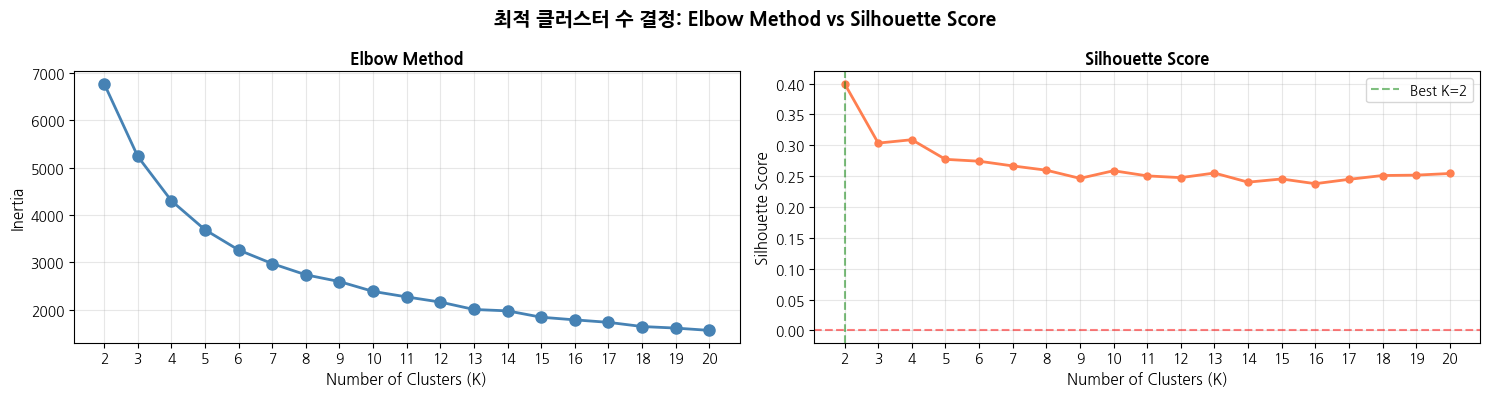

💡 종합 판단:
- Silhouette Score 기준 최적 K: 2
- Elbow Method에서도 K=3~5 정도가 적절해 보임
- RFM 분석에서 3등급(bronze, silver, gold)을 사용했으므로 K=3도 고려 가능
- 비즈니스 해석의 용이성을 고려하여 K=3 또는 K=4를 선택할 수 있음


In [46]:
# Elbow Method와 Silhouette Score 비교 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

# Elbow Method
ax1.plot(range_n_clusters, inertia, marker='o', linewidth=2, markersize=8, color='steelblue')
ax1.set_title('Elbow Method', fontsize=12, fontweight='bold')
ax1.set_xlabel('Number of Clusters (K)', fontsize=11)
ax1.set_ylabel('Inertia', fontsize=11)
ax1.set_xticks(range_n_clusters)
ax1.grid(True, alpha=0.3)

# Silhouette Score
ax2.plot(range_n_clusters, silhouettes, marker='o', linewidth=2, markersize=5, color='coral')
ax2.set_title('Silhouette Score', fontsize=12, fontweight='bold')
ax2.set_xlabel('Number of Clusters (K)', fontsize=11)
ax2.set_ylabel('Silhouette Score', fontsize=11)
ax2.set_xticks(range_n_clusters)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)

# 최고 점수 표시
ax2.axvline(x=best_k, color='green', linestyle='--', alpha=0.5, label=f'Best K={best_k}')
ax2.legend()

plt.suptitle('최적 클러스터 수 결정: Elbow Method vs Silhouette Score',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("💡 종합 판단:")
print(f"- Silhouette Score 기준 최적 K: {best_k}")
print("- Elbow Method에서도 K=3~5 정도가 적절해 보임")
print("- RFM 분석에서 3등급(bronze, silver, gold)을 사용했으므로 K=3도 고려 가능")
print("- 비즈니스 해석의 용이성을 고려하여 K=3 또는 K=4를 선택할 수 있음")

### 6.4 KElbowVisualizer 활용 (선택사항)

### 📖 Yellowbrick이란?

**Yellowbrick**은 머신러닝 모델의 성능을 시각화하는 라이브러리입니다.

- **KElbowVisualizer**: Elbow Method를 자동으로 시각화
- **장점**: 최적 K를 자동으로 추천
- **단점**: 추가 라이브러리 설치 필요


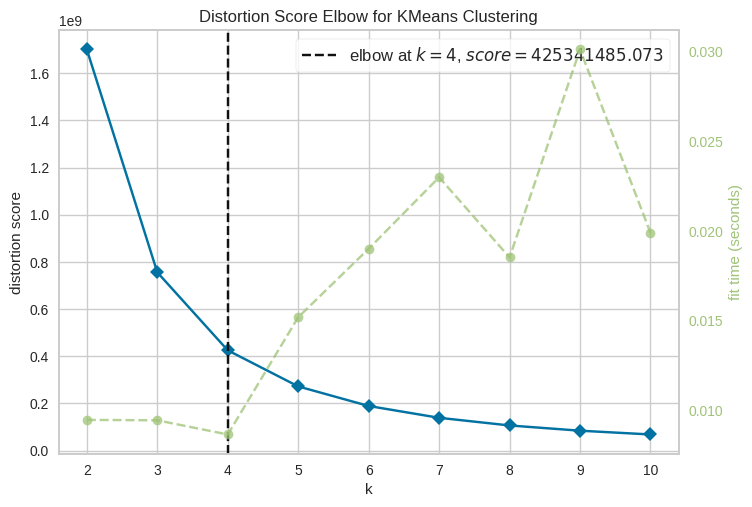

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [48]:
# TODO: KElbowVisualizer를 사용하세요 (yellowbrick이 설치된 경우)
# from yellowbrick.cluster import KElbowVisualizer를 사용하세요
# KMeans 모델을 생성하고 KElbowVisualizer를 사용하여 시각화하세요

!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer
kmeans = KMeans(random_state=42, n_init='auto')
visualizer = KElbowVisualizer(kmeans, k=(2, 11), force_modul=True)
visualizer.fit(X)
visualizer.show()


## 7. 최종 클러스터링 수행


In [51]:
# TODO: 최적 클러스터 수를 결정하고 최종 K-Means 모델을 학습하세요
# Silhouette Score가 가장 높은 K를 선택하거나, 비즈니스 맥락을 고려하여 K=3 선택
# KMeans를 생성하고 fit()을 사용하여 학습하세요
# labels_ 속성을 사용하여 클러스터 레이블을 확인하세요

n_cluster = 3
kmeans = KMeans(n_clusters=n_cluster, random_state=42, n_init='auto')
kmeans.fit(X.drop(columns=['index'])) # 'index' 컬럼 제외하고 학습

print(f"\n클러스터 중심점:")
print(pd.DataFrame(kmeans.cluster_centers_))

print(f"\n클러스터 고객 수:")
cluster_count= pd.Series(kmeans.labels_).value_counts().sort_index()
print(cluster_count)

print(f"\n클러스터 고객 비율:")
print((cluster_count/len(X) *100).round(2))


클러스터 중심점:
          0         1         2
0 -0.045297  0.144191  0.081439
1  0.795653 -0.975224 -0.917815
2 -1.098231  1.183660  1.213384

클러스터 고객 수:
0    1845
1    1494
2     999
Name: count, dtype: int64

클러스터 고객 비율:
0    42.53
1    34.44
2    23.03
Name: count, dtype: float64


In [52]:
# TODO: 클러스터 레이블을 원본 RFM 데이터에 추가하세요
# rfm["Cluster"] = kmeans.labels_를 사용하여 클러스터 레이블을 추가하세요
rfm["cluster"] = kmeans.labels_
rfm.head(10)


,CustomerID,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class,cluster
Recency,,,,,,,,,,
326,12346.0,1,77183.60,1,1,5,115,7,bronze,0
2,12347.0,182,4310.00,5,5,5,555,15,gold,2
75,12348.0,27,1595.64,2,2,4,224,8,silver,0
19,12349.0,73,1757.55,4,4,4,444,12,gold,0
310,12350.0,17,334.40,1,2,2,122,5,bronze,1
36,12352.0,83,2042.24,3,4,4,344,11,silver,0
204,12353.0,4,89.00,1,1,1,111,3,bronze,1
232,12354.0,58,1079.40,1,4,4,144,9,silver,0
214,12355.0,13,459.40,1,1,2,112,4,bronze,1


## 8. 실루엣 분석 시각화

- https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

### 📖 실루엣 분석이란?

**실루엣 분석**은 각 클러스터의 품질을 상세히 평가하는 방법입니다.

#### 실루엣 플롯 해석:

- **각 클러스터의 실루엣 계수**: 클러스터별로 색상으로 구분
- **평균 실루엣 점수**: 빨간 점선으로 표시
- **클러스터 크기**: 세로축의 길이
- **클러스터 간 분리도**: 클러스터들이 잘 분리되어 있는지 확인

#### 좋은 클러스터링의 조건:

1. 모든 클러스터의 평균 실루엣 점수가 전체 평균에 가까움
2. 클러스터 내 실루엣 점수가 균일함
3. 클러스터들이 잘 분리되어 있음


In [ ]:
# TODO: silhouette_score를 구하세요
# silhouette_score(X, kmeans.labels_)를 사용하여 평균 실루엣 점수를 계산하세요

In [ ]:
# # https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# from sklearn.metrics import silhouette_samples
# import matplotlib.cm as cm

# # Create a subplot with 1 row and 2 columns
# fig, (ax1, ax2) = plt.subplots(1, 2)
# fig.set_size_inches(18, 7)

# # The 1st subplot is the silhouette plot
# # The silhouette coefficient can range from -1, 1 but in this example all
# # lie within [-0.1, 1]
# ax1.set_xlim([-0.1, 1])
# # The (n_clusters+1)*10 is for inserting blank space between silhouette
# # plots of individual clusters, to demarcate them clearly.
# ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

# cluster_labels = kmeans.labels_
# sample_silhouette_values = silhouette_samples(X, cluster_labels)

# y_lower = 10
# for i in range(n_clusters):
#     # Aggregate the silhouette scores for samples belonging to
#     # cluster i, and sort them
#     ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

#     ith_cluster_silhouette_values.sort()

#     size_cluster_i = ith_cluster_silhouette_values.shape[0]
#     y_upper = y_lower + size_cluster_i

#     color = cm.nipy_spectral(float(i) / n_clusters)
#     ax1.fill_betweenx(
#         np.arange(y_lower, y_upper),
#         0,
#         ith_cluster_silhouette_values,
#         facecolor=color,
#         edgecolor=color,
#         alpha=0.7,
#     )

#     # Label the silhouette plots with their cluster numbers at the middle
#     ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

#     # Compute the new y_lower for next plot
#     y_lower = y_upper + 10  # 10 for the 0 samples

# ax1.set_title("The silhouette plot for the various clusters.")
# ax1.set_xlabel("The silhouette coefficient values")
# ax1.set_ylabel("Cluster label")

# # The vertical line for average silhouette score of all the values
# ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

# ax1.set_yticks([])  # Clear the yaxis labels / ticks
# ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# # 2nd Plot showing the actual clusters formed
# colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
# ax2.scatter(
#     X.iloc[:, 0], X.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
# )

# # Labeling the clusters
# centers = kmeans.cluster_centers_
# # Draw white circles at cluster centers
# ax2.scatter(
#     centers[:, 0],
#     centers[:, 1],
#     marker="o",
#     c="white",
#     alpha=1,
#     s=200,
#     edgecolor="k",
# )

# for i, c in enumerate(centers):
#     ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

# ax2.set_title("The visualization of the clustered data.")
# ax2.set_xlabel("Feature space for the 1st feature")
# ax2.set_ylabel("Feature space for the 2nd feature")

# plt.suptitle(
#     "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
#     % n_clusters,
#     fontsize=14,
#     fontweight="bold",
# )

# plt.show()

In [ ]:
# TODO: 클러스터별 RFM 평균값을 분석하세요
# rfm.groupby("Cluster").agg()를 사용하여 다음을 계산하세요:
# - Recency: ["mean", "std"]
# - Frequency: ["mean", "std"]
# - MonetaryValue: ["mean", "std", "sum", "count"]
# 컬럼명을 변경하고 스타일을 적용하여 시각화하세요

In [ ]:
import koreanize_matplotlib

# 클러스터별 시각화
fig, axes = plt.subplots(___, ___, figsize=(___, ___))

# 1. 클러스터별 고객 수
cluster_counts = rfm[___].value_counts().sort_index()
axes[0, 0].bar(cluster_counts.___, cluster_counts.___, color=['steelblue', 'coral', 'green'])
axes[0, 0].set_title('클러스터별 고객 수', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('클러스터')
axes[0, 0].set_ylabel('고객 수')
for i, v in enumerate(cluster_counts.values):
    axes[0, 0].text(i, v, f'{v:,}', ha='center', va='bottom')

# 2. 클러스터별 평균 RFM 값 비교
cluster_rfm_mean = rfm.groupby(___)[[___, ___, ___]].mean()
cluster_rfm_mean.plot(kind='bar', ax=axes[0, 1], color=['steelblue', 'coral', 'green'])
axes[0, 1].set_title('클러스터별 평균 RFM 값', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('클러스터')
axes[0, 1].set_ylabel('평균값')
axes[0, 1].legend(title='RFM 지표')
axes[0, 1].tick_params(axis='x', rotation=0)

# 3. 클러스터별 RFM 지표 박스플롯
rfm_melted = rfm.melt(id_vars=[___],
                      value_vars=[___, ___, ___],
                      var_name='지표', value_name='값')
# MonetaryValue는 로그 변환
rfm_melted.loc[rfm_melted['지표'] == 'MonetaryValue', '값'] = ___.___(rfm_melted.loc[rfm_melted['지표'] == 'MonetaryValue', '값'])
sns.boxplot(data=rfm_melted, x=___, y=___, hue=___, ax=axes[1, 0])
axes[1, 0].set_title('클러스터별 RFM 지표 분포 (MonetaryValue는 로그 변환)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('클러스터')
axes[1, 0].set_ylabel('값')

# 4. 클러스터별 총 매출 비율 (파이 차트)
total_sales_by_cluster = rfm.groupby(___)[___].sum()
axes[1, 1].pie(total_sales_by_cluster.___, labels=total_sales_by_cluster.___,
               autopct='%1.1f%%', colors=['steelblue', 'coral', 'green'], startangle=90)
axes[1, 1].set_title('클러스터별 총 매출 비율', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### 9.2 규칙 기반(RFM) vs 데이터 기반(Clustering) 비교

### 📖 두 방법의 차이점

#### 규칙 기반 세분화 (RFM):

- **방법**: qcut을 사용한 분위수 기반 분류
- **장점**: 해석이 쉬움, 비즈니스 직관과 일치
- **단점**: 고정된 규칙, 복잡한 패턴 발견 어려움

#### 데이터 기반 세분화 (Clustering):

- **방법**: K-Means를 사용한 거리 기반 군집화
- **장점**: 데이터의 숨겨진 패턴 발견, 유연함
- **단점**: 해석이 어려울 수 있음, K 결정 필요


In [54]:
# TODO: RFM_class와 Cluster의 교차표를 생성하고 시각화하세요
# pd.crosstab()을 사용하여 교차표를 생성하세요
# sns.heatmap()을 사용하여 시각화하세요 (crosstab.iloc[:-1, :-1]을 사용하여 마진 제외)
crosstab= pd.crosstab(rfm["RFM_class"], rfm["cluster"])
crosstab


cluster,0,1,2
RFM_class,,,
bronze,201,1480,0
gold,280,0,980
silver,1364,14,19


In [ ]:
# 클러스터별 상세 분석 (Pairplot)
# 샘플링하여 시각화 (너무 많으면 느림)
sample_size = min(___, len(rfm))
rfm_sample = rfm.sample(sample_size, random_state=___)

sns.pairplot(rfm_sample[[___, ___, ___, ___]],
             hue=___, palette={0: 'steelblue', 1: 'coral', 2: 'green'},
             diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('클러스터별 RFM 지표 분포 (Pairplot)', y=1.02, fontsize=14, fontweight='bold')
plt.show()

### 9.3 클러스터별 비즈니스 인사이트

### 💡 인사이트

각 클러스터의 특성을 분석하여 비즈니스 전략을 수립할 수 있습니다:

#### 클러스터 해석 예시:

1. **클러스터 0**:
   - 특성: Recency 높음, Frequency 낮음, Monetary 낮음
   - 해석: 오래 전에 구매했고, 구매 빈도와 금액이 낮은 고객
   - 전략: 재활성화 캠페인, 특가 프로모션
   - 예상 효과: 이탈 방지, 재구매 유도

2. **클러스터 1**:
   - 특성: Recency 중간, Frequency 중간, Monetary 중간
   - 해석: 중간 수준의 고객, 성장 가능성 있음
   - 전략: 업셀링/크로스셀링, 구매 빈도 증가 캠페인
   - 예상 효과: 고객 가치 향상, VIP 고객으로 전환

3. **클러스터 2**:
   - 특성: Recency 낮음, Frequency 높음, Monetary 높음
   - 해석: 최근에 구매했고, 자주 구매하며, 금액도 높은 VIP 고객
   - 전략: 유지 및 로열티 프로그램 강화, 프리미엄 서비스 제공
   - 예상 효과: 고객 유지, 생애 가치(CLV) 향상

### 📊 클러스터링 vs 규칙 기반 비교

| 구분              | 규칙 기반 (RFM)  | 데이터 기반 (Clustering) |
| ----------------- | ---------------- | ------------------------ |
| **방법**          | qcut 분위수 기반 | K-Means 거리 기반        |
| **해석**          | 직관적, 쉬움     | 복잡할 수 있음           |
| **유연성**        | 고정된 규칙      | 데이터 패턴 기반         |
| **변수 수**       | 적은 변수에 적합 | 많은 변수에 적합         |
| **비즈니스 이해** | 높음             | 중간                     |
| **숨겨진 패턴**   | 발견 어려움      | 발견 가능                |


### 9.4 클러스터링의 활용 범위

### 📖 언제 클러스터링을 사용해야 할까?

#### 규칙 기반 방법(qcut)이 적합한 경우:

- 변수가 적을 때 (예: RFM 3개 변수)
- 비즈니스 해석이 중요한 경우
- 직관적이고 명확한 규칙이 필요한 경우

#### 클러스터링이 적합한 경우:

- 변수가 많을 때 (예: 설문조사, 사용자 행동 정보, 인구통계학적 정보)
- 복잡한 패턴을 발견하고자 할 때
- 규칙 기반 방법의 전처리가 까다로울 때
- 데이터 기반으로 자동화된 세분화가 필요할 때

### 💡 실무 활용 예시:

- **설문조사 데이터**: 다양한 질문 항목을 종합하여 고객 그룹화
- **사용자 행동 정보**: 웹사이트 방문 패턴, 클릭 행동 등
- **인구통계학적 정보**: 연령, 지역, 소득 등 다양한 특성
- **제품 선호도**: 다양한 제품 카테고리별 구매 패턴


## 10. 데이터 저장 및 다음 단계


In [55]:
# TODO: 클러스터링 결과를 CSV 파일로 저장하세요
# rfm.to_csv("rfm_with_cluster.csv")를 사용하여 저장하세요
rfm.to_csv("rfm_with_cluster.csv")

---

## 🎯 실습 요약

### ✅ 배운 내용
1. ✅ **비지도 학습**의 개념 이해
2. ✅ **K-Means 클러스터링** 알고리즘의 원리와 활용
3. ✅ **데이터 전처리**: 로그 변환, 스케일 조정
4. ✅ **최적 클러스터 수 결정**: Elbow Method, Silhouette Score
5. ✅ **실루엣 분석**: 클러스터링 품질 평가
6. ✅ **클러스터 분석**: 규칙 기반 vs 데이터 기반 비교
7. ✅ **비즈니스 인사이트** 도출

### 📊 주요 기법
- **로그 변환**: `np.log1p()` - 정규 분포에 가깝게 변환
- **스케일 조정**: `StandardScaler` - 평균 0, 표준편차 1로 변환
- **K-Means**: `sklearn.cluster.KMeans` - 거리 기반 클러스터링
- **Elbow Method**: Inertia를 사용한 최적 K 찾기
- **Silhouette Score**: 클러스터링 품질 평가 지표

### 💡 핵심 개념
- **비지도 학습**: 레이블 없이 데이터 패턴 찾기
- **K-Means**: 거리 기반 클러스터링 알고리즘
- **전처리의 중요성**: 로그 변환과 스케일 조정이 필수
- **최적 K 결정**: Elbow Method와 Silhouette Score 함께 사용
- **규칙 vs 데이터**: 두 방법의 장단점 이해

### 🚀 다음 단계
- **Part 3**: 이탈률 예측 모델 구축 (지도 학습)
- **실무 적용**: 클러스터별 맞춤형 마케팅 전략 수립

---

## 📚 참고 자료

- [Clustering — scikit-learn documentation](https://scikit-learn.org/stable/modules/clustering.html#clustering)
- [k-평균 알고리즘 - 위키백과](https://ko.wikipedia.org/wiki/K-%ED%8F%89%EA%B7%A0_%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98)
- [Silhouette Score - scikit-learn](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient)
- [Yellowbrick Documentation](https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html)

---
